# Reproject your data
PolarToolkit works exclusively with data projected in either EPSG 3031 or EPSG 3413, for Antarctica and the Arctic/Greenland, respectively. These projections have units of meters and are relative to the poles. If you have your own data which you want to use in PolarToolkit, you may need to reproject it into these projections if its not already in them. Here we'll demonstrate the basics of how to do this.

In [1]:
import os

import polartoolkit as ptk

In [2]:
# set default projection to South Polar Stereographic for this notebook
os.environ["POLARTOOLKIT_EPSG"] = "3031"

## Convert a region from lat lon to projected meters with an EPSG projection
If you have a geographic bounding region in latitude and longitude in the format (lon_min, lon_max, lat_min, lat_max) you can use `region_ll_to_xy` to project it to an EPSG projection, or `region_xy_to_ll` for the opposite.

In [3]:
region_lat_lon = (-104.40, -92.33, -76.42, -73.89)
region_xy = ptk.region_ll_to_xy(region_lat_lon)
region_xy

(np.float64(-1760092.1034694898),
 np.float64(-1435602.3038731467),
 np.float64(-438079.2907721378),
 np.float64(-60257.458812579534))

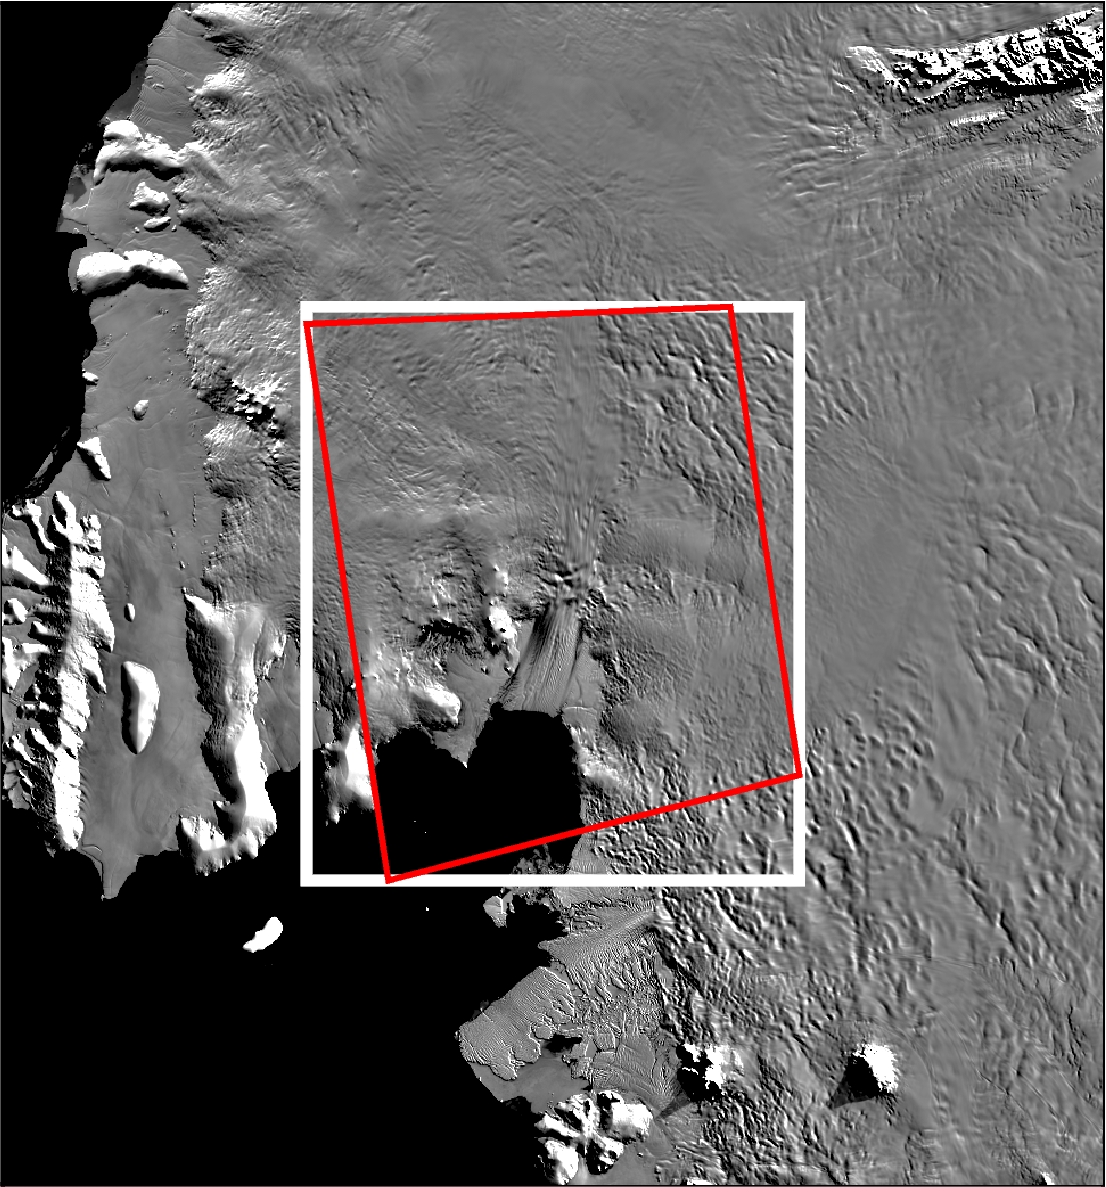

In [4]:
figure_region = ptk.alter_region(region_xy, zoom=-200e3)

fig = ptk.basemap(
    modis_basemap=True,
    region=figure_region,
)

# plot EPSG bounding region as a white box
fig.plot(
    x=[region_xy[0], region_xy[0], region_xy[1], region_xy[1], region_xy[0]],
    y=[region_xy[2], region_xy[3], region_xy[3], region_xy[2], region_xy[2]],
    pen="4p,white",
)

# plot equivalent lat/lon bounding region as a red box
# for this, we need to inform pygmt that we are plotting in geographic coordinates
# so we set the 'region' and 'projection' to pre-stored attributes fig.reg_latlon and
# fig.proj_latlon, respectively.
fig.plot(
    x=[
        region_lat_lon[0],
        region_lat_lon[0],
        region_lat_lon[1],
        region_lat_lon[1],
        region_lat_lon[0],
    ],
    y=[
        region_lat_lon[2],
        region_lat_lon[3],
        region_lat_lon[3],
        region_lat_lon[2],
        region_lat_lon[2],
    ],
    pen="2p,red",
    projection=fig.proj_latlon,
    region=fig.reg_latlon,
)

fig.show(dpi=200)

The same can be done for coordinate pairs, or a pandas DataFrame of coordinates.

In [5]:
xy_coords = (-360000, -1100000)

lat_lon_coords = ptk.reproject(
    xy_coords,
    input_crs="3031",  # south polar stereographic
    output_crs="4326",  # lat / long
)

print(lat_lon_coords)

(-161.87813975209863, -79.37689147851952)


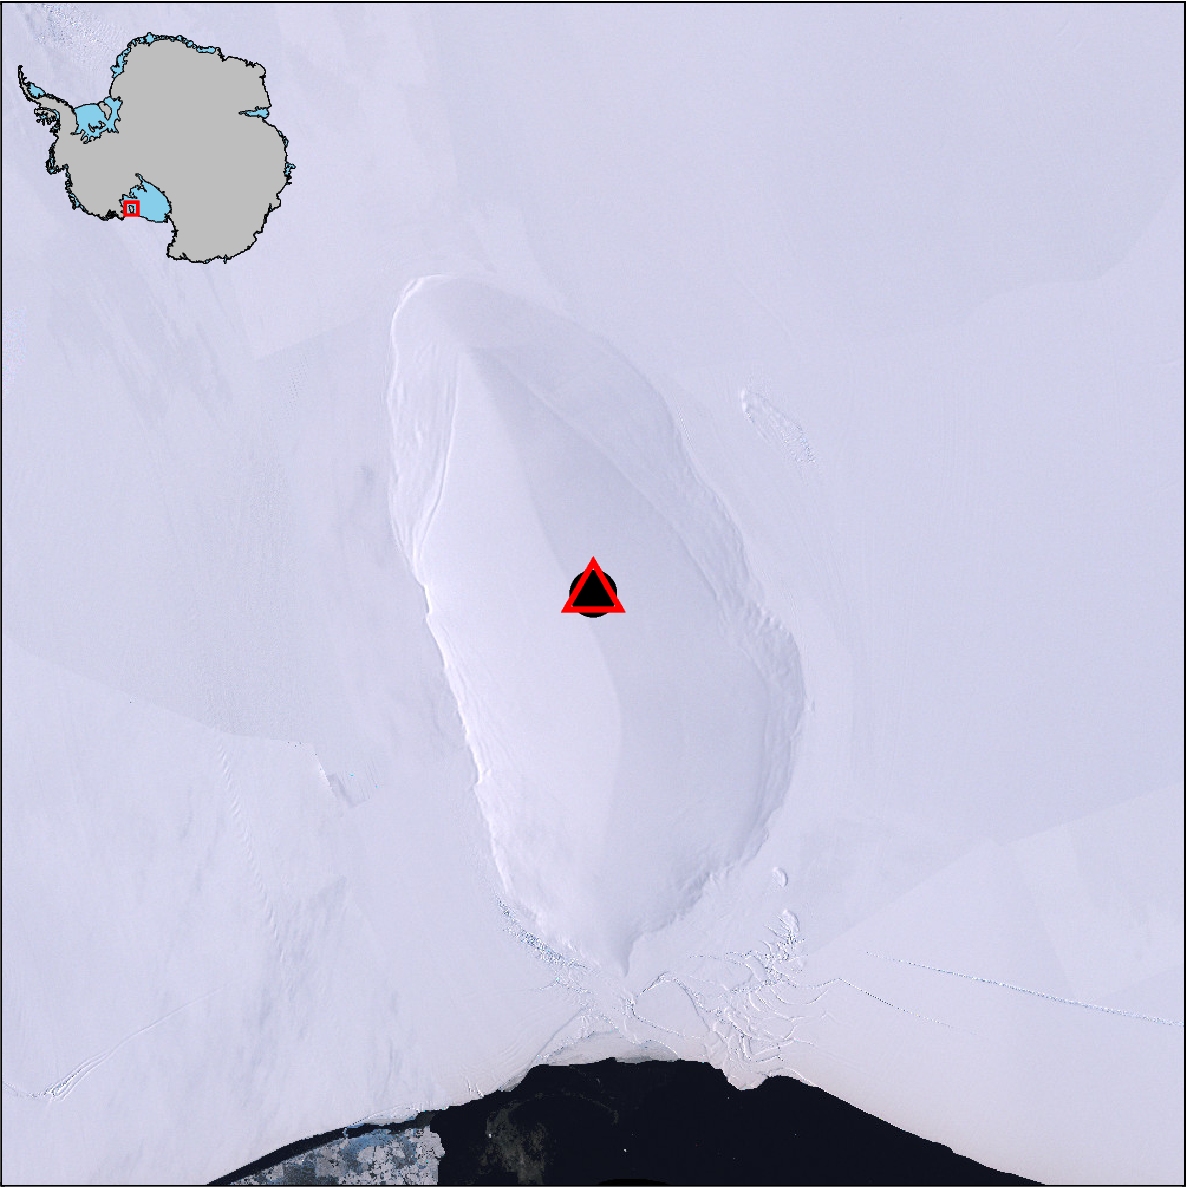

In [6]:
# plot a basemap with imagery
fig = ptk.basemap(
    imagery_basemap=True,
    region=ptk.regions.roosevelt_island,
    inset=True,
)

# add the coordinate point in projected units as a black dot
fig.plot(
    x=xy_coords[0],
    y=xy_coords[1],
    style="c.6c",
    fill="black",
)

# add the coordinate point in lat/lon as a red triangle
# plot equivalent lat/lon bounding region as a red box
# for this, we need to inform pygmt that we are plotting in geographic coordinates
# so we set the 'region' and 'projection' to pre-stored attributes fig.reg_latlon and
# fig.proj_latlon, respectively.
fig.plot(
    x=lat_lon_coords[0],
    y=lat_lon_coords[1],
    style="t.8c",
    pen="2p,red",
    projection=fig.proj_latlon,
    region=fig.reg_latlon,
)
fig.show(dpi=200)

If you have gridded data which needs to be reprojected, we recommend the `rioxarray` package with an example shown below.

In [7]:
# fetch a grid which is already in EPSG:3031
grid = ptk.fetch.sediment_thickness(
    version="GlobSed",
    spacing=5e3,
    region=ptk.regions.roosevelt_island,
    verbose="error",
)

# tell rioxarray what the current projection is
grid = grid.rio.write_crs("EPSG:3031")

# reproject to lat lon
grid_ll = grid.rio.reproject("EPSG:4326", resolution=0.05)

# reproject back to EPSG to see if it worked
grid_xy = grid_ll.rio.reproject("EPSG:3031", resolution=5e3)

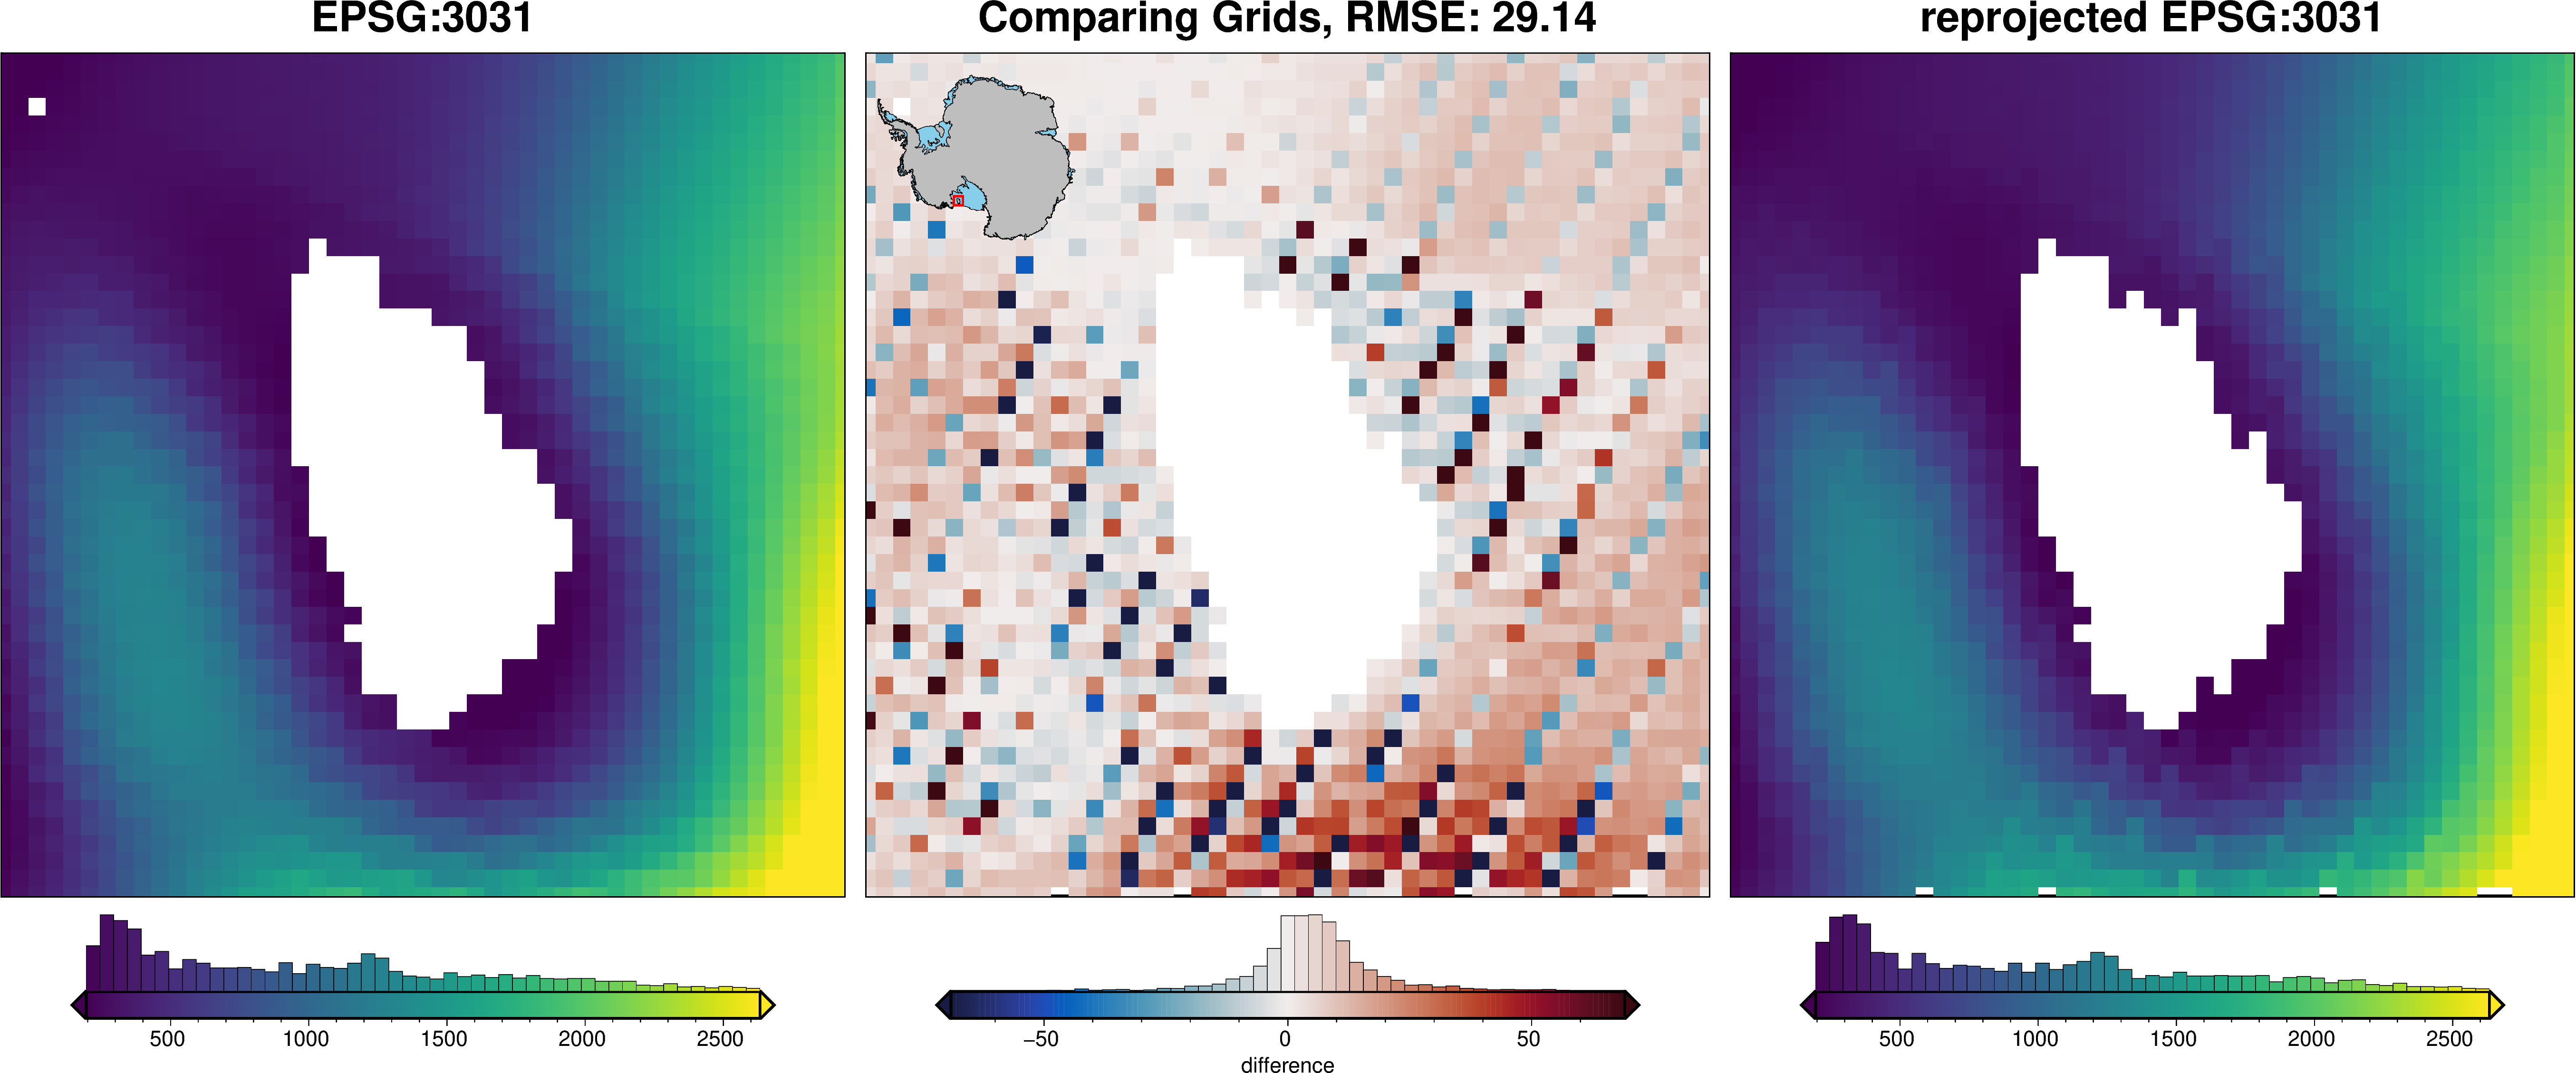

In [8]:
_ = ptk.grid_compare(
    grid,
    grid_xy,
    hist=True,
    robust=True,
    grid1_name="EPSG:3031",
    grid2_name="reprojected EPSG:3031",
)